# Modeling

In [1]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):
    
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))  / MULTIPLIER
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [2]:
with open('./dataset_0.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [3]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9483 entries, 0 to 9482
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age_access_type    9483 non-null   int64  
 1   average_rating     8958 non-null   float64
 2   duration           9483 non-null   float64
 3   type               9483 non-null   object 
 4   name               9483 non-null   object 
 5   release_year       9483 non-null   object 
 6   target             9483 non-null   float64
 7   subscription_only  9483 non-null   object 
 8   actor_0            9483 non-null   object 
 9   actor_1            9483 non-null   object 
 10  actor_2            9483 non-null   object 
 11  actor_3            9483 non-null   object 
 12  actor_4            9483 non-null   object 
 13  country_0          9483 non-null   object 
 14  genre_0            9483 non-null   object 
 15  genre_1            9483 non-null   object 
 16  genre_2            9483 

# Preprocessing

In [4]:
cat_features = ['type', 'subscription_only', 'actor_0', 'actor_1',
               'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
               'genre_2', 'director_0', 'SUBSCRIPTION', 'AVOD', 'DTO', 'RENT']
num_features = ['age_access_type', 'average_rating', 'duration']

target_transformer = TargetTransformer()

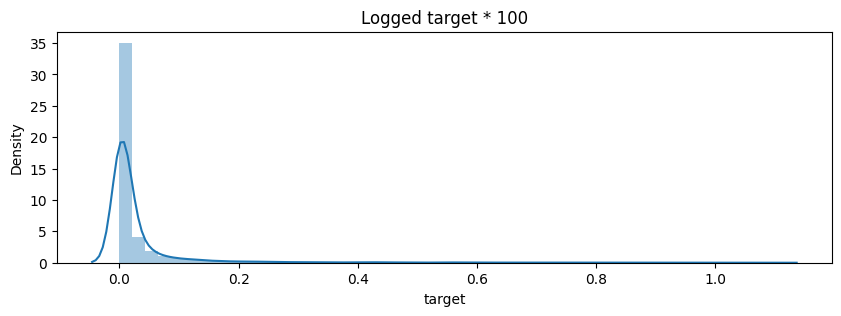

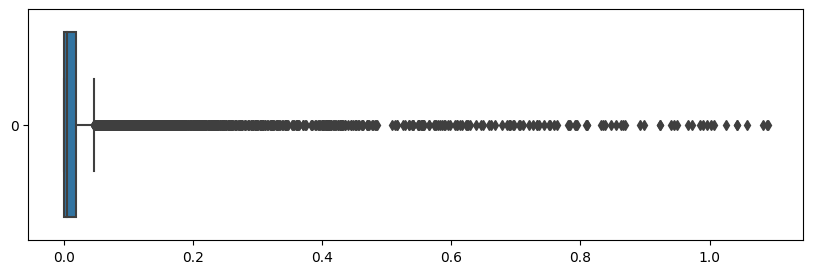

In [5]:
MULTIPLIER = 100
X, y = df_pr.drop(['target', 'name', 'release_year'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)


plt.figure(figsize=(10, 3))
sns.distplot(y)
plt.title(f'Logged target * {MULTIPLIER}')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(y, orient='h')
plt.show()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [51]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

Learning rate set to 0.017502
0:	learn: 1.7003589	test: 1.6888486	best: 1.6888486 (0)	total: 12.6ms	remaining: 2m 5s
100:	learn: 1.5381708	test: 1.5231673	best: 1.5231673 (100)	total: 1.06s	remaining: 1m 43s
200:	learn: 1.4788594	test: 1.4686190	best: 1.4686190 (200)	total: 2.11s	remaining: 1m 43s
300:	learn: 1.4480677	test: 1.4468513	best: 1.4466202 (298)	total: 3.17s	remaining: 1m 42s
400:	learn: 1.4244280	test: 1.4311445	best: 1.4311445 (400)	total: 4.22s	remaining: 1m 40s
500:	learn: 1.4059759	test: 1.4183722	best: 1.4182168 (494)	total: 5.25s	remaining: 1m 39s
600:	learn: 1.3861677	test: 1.4093714	best: 1.4093714 (600)	total: 6.3s	remaining: 1m 38s
700:	learn: 1.3694271	test: 1.3982612	best: 1.3981377 (697)	total: 7.36s	remaining: 1m 37s
800:	learn: 1.3568813	test: 1.3890942	best: 1.3890942 (800)	total: 8.4s	remaining: 1m 36s
900:	learn: 1.3452584	test: 1.3838944	best: 1.3835864 (887)	total: 9.46s	remaining: 1m 35s
1000:	learn: 1.3338227	test: 1.3768758	best: 1.3768597 (999)	total

In [59]:
cat_model.save_model('2')

In [60]:
y_pred = cat_model.predict(X_test)

In [61]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   1859117.4423789755
RMSE:  1363.494569985145
R2:    0.023711450390574873
MAE:   353.8244251297264
MedAE: 48.19636635511948
Adj_R2:  0.02175123878298968
------------------------------


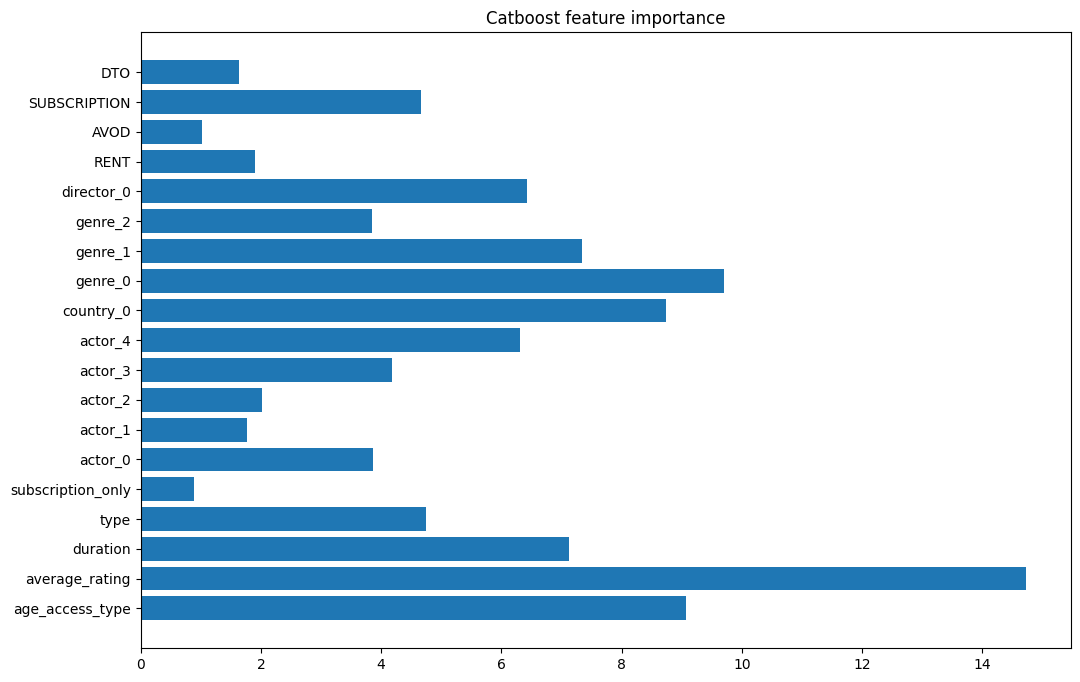

In [62]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

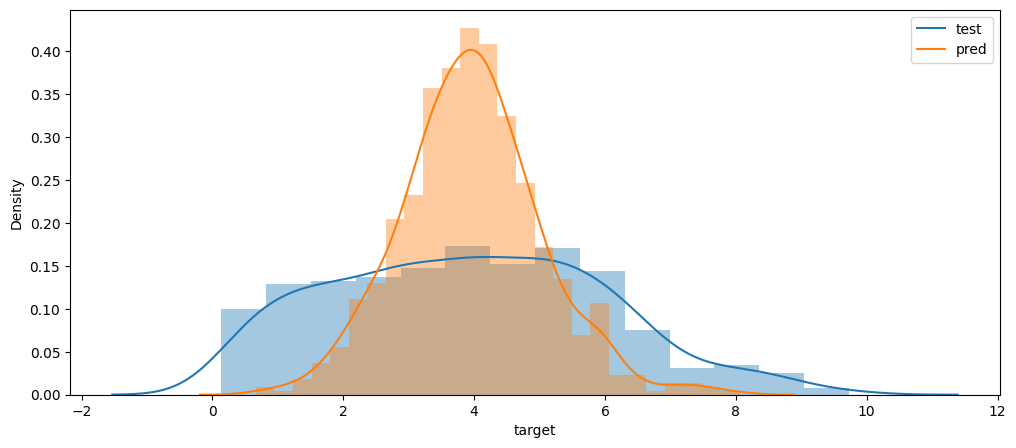

In [56]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

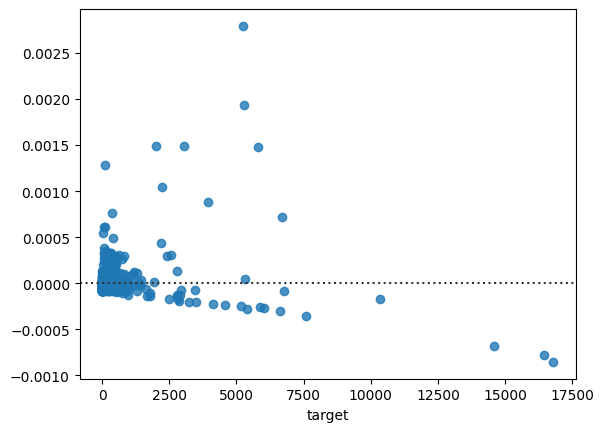

In [57]:
draw_residuals(y_test, y_pred, save_fig=False)

In [58]:
len(y_pred[y_pred <= 0])

0